In [1]:
%ls

In [2]:
import numpy as np
import cv2 as cv
import os
import re
from Visualization import *
from hough_transform import *

import matplotlib.pyplot as plt

Visualization.py loaded


In [3]:
video_dir = os.path.join('Lane_Parameters', 'Lane_Videos')
lane_dir = os.path.join('Lane_Parameters', 'Lane_Parameters')
def get_video(video_num):
    return os.path.join(video_dir, 'IMG_'+ video_num + '.MOV')


def get_lanes(video_num, frame_num, factor = 1):
    
    p = re.compile('[0-9]*,[0-9]*')
    file = open(os.path.join(lane_dir, video_num, str(frame_num) + '.txt'))
    lanes = []

    for line in file:
        points = p.findall(line)
        for i, point in enumerate(points):
            points[i] = tuple(map(int, point.split(',')))
            points[i] = int(points[i][0]/factor), int(points[i][1]/factor)
        
        lanes.append(points)
    file.close()
    return lanes

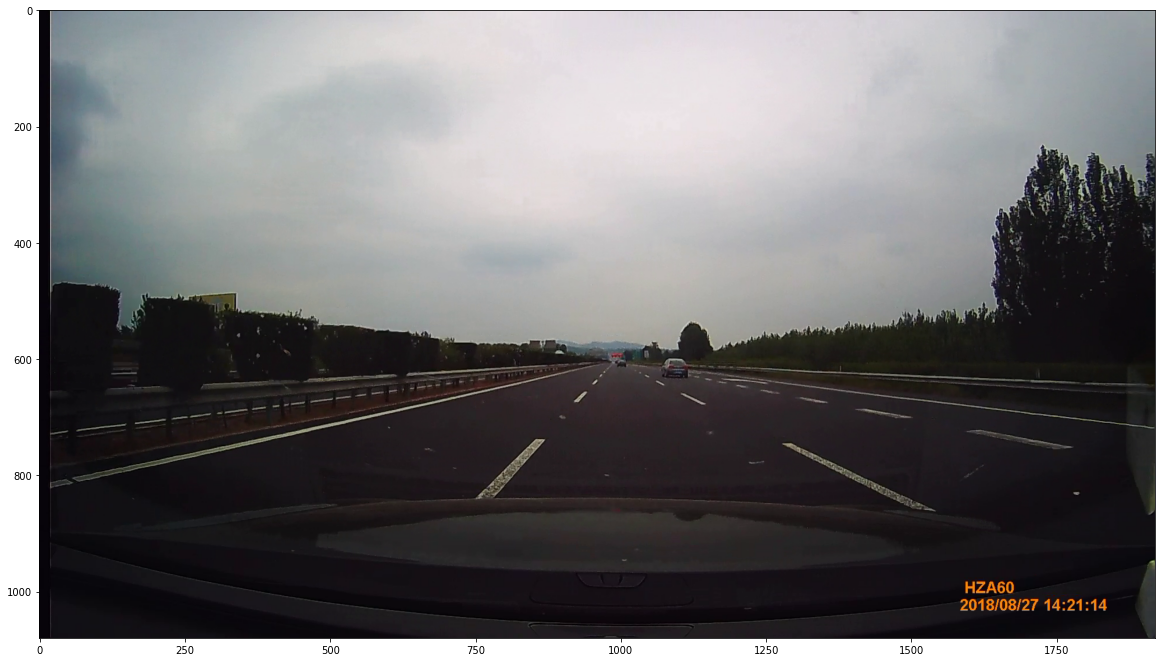

In [17]:
video_num = '0250'
vid = cv.VideoCapture(get_video(video_num))

frame_num = 1000

for i in range(frame_num):
    sucess, orignal_frame = vid.read()
    if not sucess:
        break
vid.release()


img = orignal_frame.copy()

factor = 2

img = cv.resize(img,(0,0), fx=1/factor, fy=1/factor)

PLTdraw(orignal_frame)

In [21]:
def draw_dots(img, dots, radius=2, color=(255,0,0), thickness=2):
    for dot in dots:
        img = cv.circle(img, dot, 2, color, thickness)
    return img

def draw_lanes(img_org, lanes, radius=3, colorLst=None, thickness=2):
    img = img_org.copy()
    for lane in lanes:
        color = None
        if colorLst is None:
            color = random_color()
        img = draw_dots(img, lane, radius, color, thickness)
    return img

In [97]:
import random as rand

def random_color():
    rand.seed(10)
    return rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)

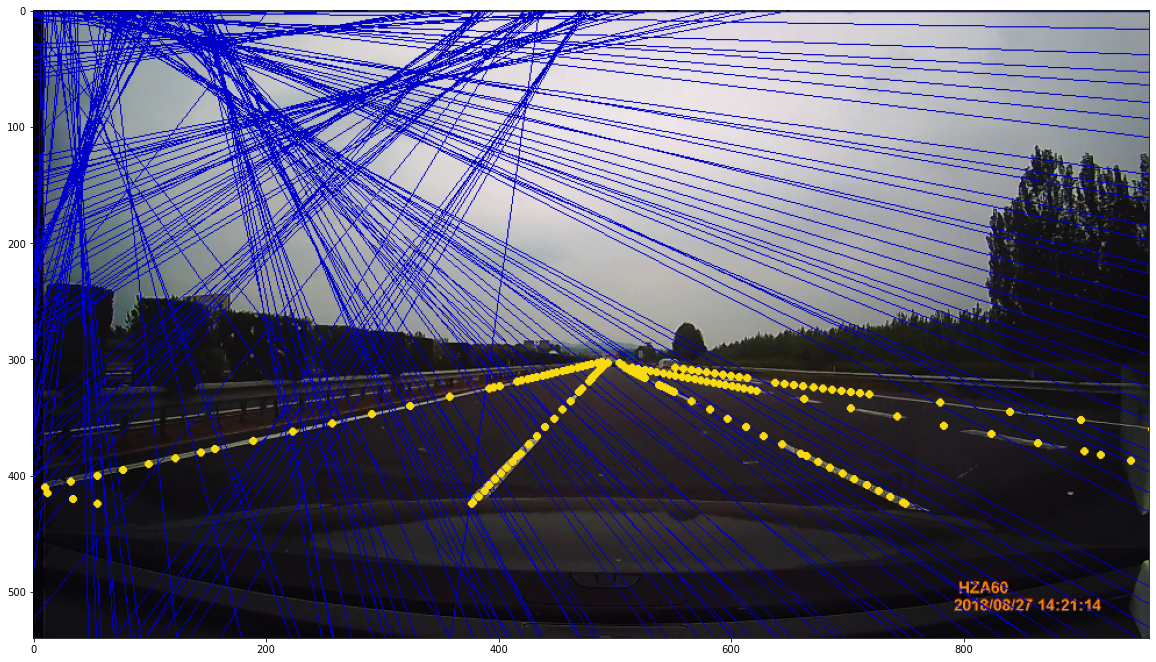

In [98]:
lanes = get_lanes(video_num, frame_num, factor)
doted = draw_lanes(img, lanes)
PLTdraw(doted)

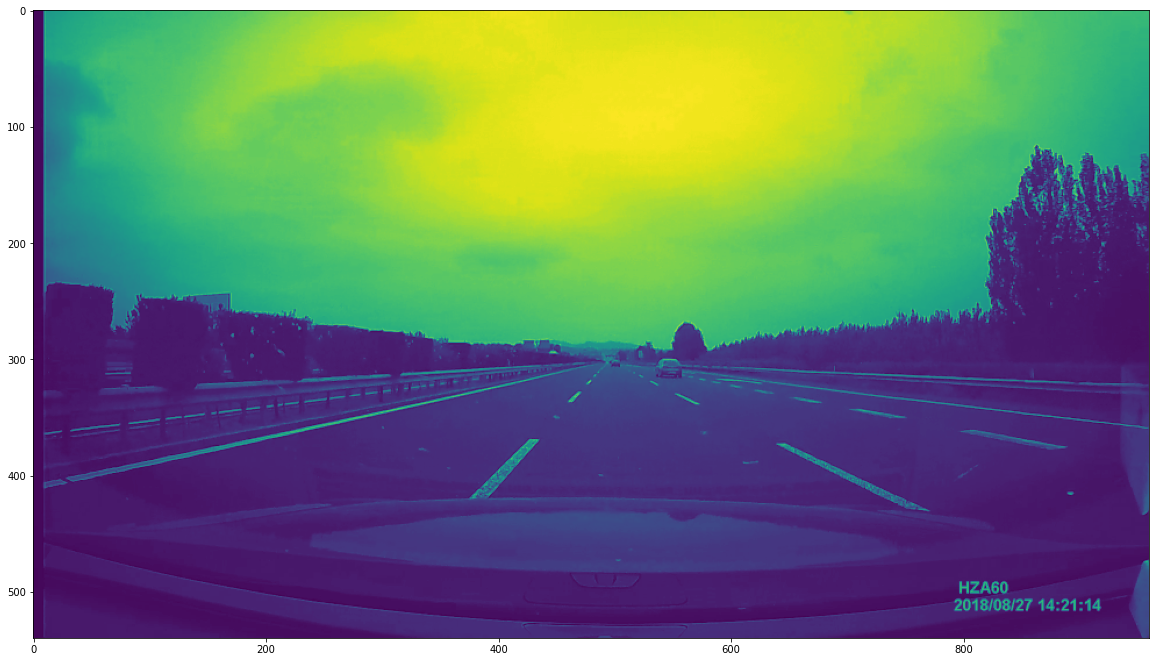

In [24]:
def bgr2gray(bgr):
    return bgr[:,:,0]*0.114 + bgr[:,:,1]*0.587 + bgr[:,:,2]*0.299

grayed = bgr2gray(img)
PLTdraw(grayed, binary=True)

## Sobel Edge Detector 
By Tharm

In [69]:
def sobel(grayed_frame):
    
    #Implementing image smoothing
    rows = grayed_frame.shape[0]
    cols = grayed_frame.shape[1]
    
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
    mag_smooth = np.zeros((rows,cols))
    
    #pad with zeros on the border for full blurring of image
    padded_gray = np.zeros((rows + 2, cols + 2))
    padded_gray[1:-1, 1:-1] = grayed_frame
    
    for x in range(rows):
        for y in range(cols):
            mag_smooth[x][y] = (kernel * padded_gray[x:x+3, y:y+3]).sum()
    
    ##Implementing sobel edge detector
    Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    
    mag_G = np.zeros((rows,cols))
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            sumx = (Gx * mag_smooth[i-1:i+2, j-1:j+2]).sum()
            sumy = (Gy * mag_smooth[i-1:i+2, j-1:j+2]).sum()
            mag_G[i][j] = np.sqrt(sumx**2 + sumy**2)

    return mag_G

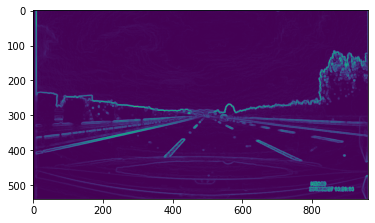

In [91]:
sobeled = sobel(grayed)
plt.imshow(sobeled)

In [92]:
sobeled = sobeled.astype(np.uint8)

In [93]:
sobeled

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   9,   7, ..., 212,  20,   0],
       [  0,   7,   0, ...,   2, 213,   0],
       ...,
       [  0,   6,   1, ...,  25,  81,   0],
       [  0,   8,   8, ...,  78, 103,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

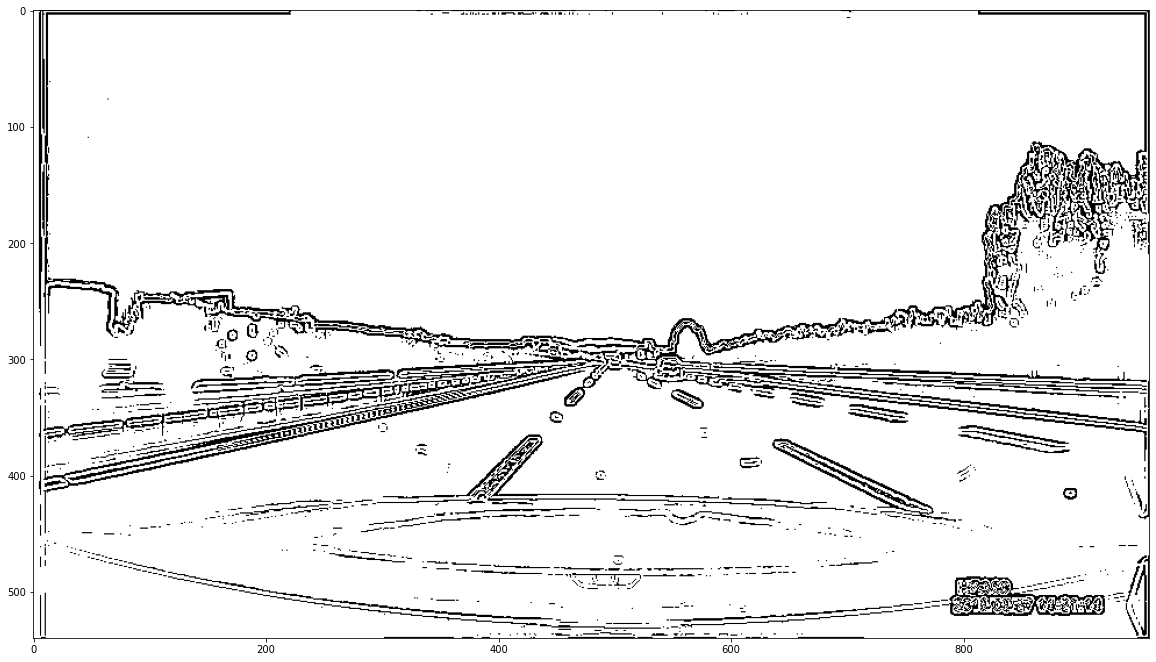

In [94]:
threshed = cv.adaptiveThreshold(
    sobeled,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,5,9)
PLTdraw(threshed)

In [95]:
hough_space = Hough_lines(threshed, 100)
len(hough_space)

179

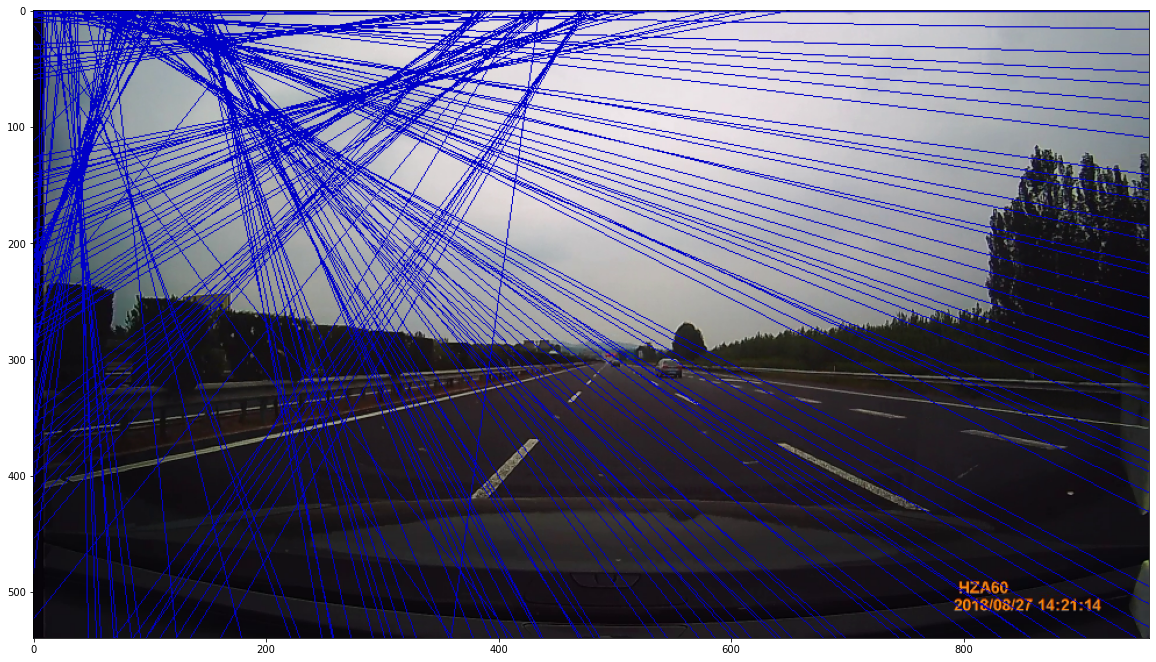

In [99]:
for i in lines:
    points = hough_intersect(i[0], i[1], img)
    #print(points)
    cv.line(img, points[0], points[1], [200])

PLTdraw(img)